In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.types import *

spark = SparkSession.builder.appName('sparkTrial').master('local').getOrCreate()
sc= spark.sparkContext

In [2]:

data = spark.read.csv('file:///D:/Ravi_Data/Pyspark/flightsFull.csv',header=True,sep=",",inferSchema=True, nullValue = "NA")
print(data.count())
data.show(5)

275000
+---+---+---+-------+------+---+----+------+--------+-----+
|mon|dom|dow|carrier|flight|org|mile|depart|duration|delay|
+---+---+---+-------+------+---+----+------+--------+-----+
| 10| 10|  1|     OO|  5836|ORD| 157|  8.18|      51|   27|
|  1|  4|  1|     OO|  5866|ORD| 466|  15.5|     102| null|
| 11| 22|  1|     OO|  6016|ORD| 738|  7.17|     127|  -19|
|  2| 14|  5|     B6|   199|JFK|2248| 21.17|     365|   60|
|  5| 25|  3|     WN|  1675|SJC| 386| 12.92|      85|   22|
+---+---+---+-------+------+---+----+------+--------+-----+
only showing top 5 rows



In [3]:
pd.set_option('max_colwidth', -1) # to prevent truncating of columns

def column_types(spark_df):
    """Count number of columns per type"""
    return pd.DataFrame(spark_df.dtypes).groupby(1, as_index=False)[0].agg({'Count':'count', 'Columns': lambda x: " | ".join(set(x))}).rename(columns={1:"Type"})

column_types(data)

,Type,Count,Columns
0,double,1,depart
1,int,7,duration | mile | delay | mon | dow | flight | dom
2,string,2,carrier | org


In [4]:
from pyspark.sql.functions import isnull, when, count
data.select([count(when(isnull(c), c)).alias(c) for c in data.columns]).toPandas()

,mon,dom,dow,carrier,flight,org,mile,depart,duration,delay
0,0,0,0,0,0,0,0,0,0,16711


In [5]:
data = data.drop("flight")
data = data.filter("duration IS NOT NULL")

In [6]:
num_cols = ["mon","dom","dow","mile","depart","delay"]
str_cols = ['carrier','org']

data = data.dropna(subset= num_cols + str_cols)
print(data.count())

data.select([count(when(isnull(c), c)).alias(c) for c in data.columns]).toPandas()

258289


,mon,dom,dow,carrier,org,mile,depart,duration,delay
0,0,0,0,0,0,0,0,0,0


In [7]:
train,test = data.randomSplit([0.7,0.3], seed = 111)
train.show(5,truncate = False)

+---+---+---+-------+---+----+------+--------+-----+
|mon|dom|dow|carrier|org|mile|depart|duration|delay|
+---+---+---+-------+---+----+------+--------+-----+
|0  |1  |2  |AA     |JFK|740 |8.58  |170     |17   |
|0  |1  |2  |AA     |JFK|944 |15.75 |185     |16   |
|0  |1  |2  |AA     |JFK|1391|14.92 |245     |6    |
|0  |1  |2  |AA     |JFK|1597|13.5  |225     |1    |
|0  |1  |2  |AA     |JFK|1623|7.17  |230     |19   |
+---+---+---+-------+---+----+------+--------+-----+
only showing top 5 rows



In [8]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

indexers = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c))for c in str_cols]

encoders = [OneHotEncoder(inputCol=indexer.getOutputCol(),
                          outputCol="{0}_encoded".format(indexer.getOutputCol())) for indexer in indexers]

assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders ] + num_cols,
                            outputCol="features")


pipeline = Pipeline(stages=indexers + encoders + [assembler])

fit_pipeline = pipeline.fit(train)

train = fit_pipeline.transform(train)
test = fit_pipeline.transform(test)

train.select("features","duration").show(5,truncate=False)

+-------------------------------------------------------------+--------+
|features                                                     |duration|
+-------------------------------------------------------------+--------+
|(21,[1,10,16,17,18,19,20],[1.0,1.0,1.0,2.0,740.0,8.58,17.0]) |170     |
|(21,[1,10,16,17,18,19,20],[1.0,1.0,1.0,2.0,944.0,15.75,16.0])|185     |
|(21,[1,10,16,17,18,19,20],[1.0,1.0,1.0,2.0,1391.0,14.92,6.0])|245     |
|(21,[1,10,16,17,18,19,20],[1.0,1.0,1.0,2.0,1597.0,13.5,1.0]) |225     |
|(21,[1,10,16,17,18,19,20],[1.0,1.0,1.0,2.0,1623.0,7.17,19.0])|230     |
+-------------------------------------------------------------+--------+
only showing top 5 rows



In [9]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol="duration", metricName="rmse")

Lreg = LinearRegression(labelCol = 'duration', regParam = 0.1,elasticNetParam =0).fit(train)
predictions = Lreg.transform(test)

# Calculate the RMSE
RMSE = evaluator.evaluate(predictions)
print("Linear Regression RMSE: ", RMSE)

Linear Regression RMSE:  10.714818763541519


In [10]:
from pyspark.ml.regression import GBTRegressor

GBT = GBTRegressor(labelCol = 'duration').fit(train)
predictions = GBT.transform(test)

# Calculate the RMSE
RMSE = evaluator.evaluate(predictions)
print("Gradient boosting RMSE: ", RMSE)

Gradient boosting RMSE:  9.327425402692475


In [11]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import CrossValidator,ParamGridBuilder

rf = RandomForestRegressor(labelCol="duration", featuresCol="features")

# grid = ParamGridBuilder() \
# .addGrid(rf.numTrees, [100,300]) \
# .addGrid(rf.maxDepth, [10,25]) \
# .build()

grid = ParamGridBuilder().build()

cv_models = CrossValidator(estimator=rf,
                    estimatorParamMaps=grid,
                    evaluator=evaluator,
                    numFolds=3).fit(train)

bestModel = cv_models.bestModel
predictions= bestModel.transform(test)

# predictions = rf.transform(test)

RMSE = evaluator.evaluate(predictions)
print("Random Forest RMSE: ", RMSE)

Random Forest RMSE:  22.233015982720158


21
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


Text(0.5,1,'Feature Importances')

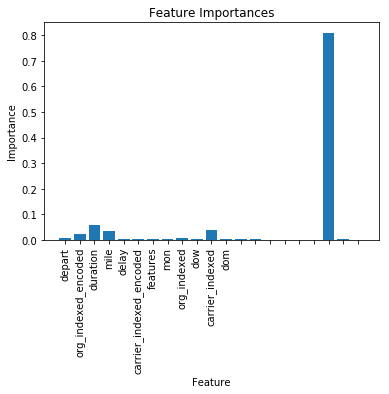

In [14]:
# # bestModel = cv_models.bestModel

#importances = bestModel.featureImportances

feature_list = list(set(train.columns)-set(str_cols))

importances = bestModel.featureImportances

print(len(importances))


x_values = list(range(len(importances)))
print(x_values)

plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values,feature_list, rotation=90)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances')